In [1]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj
from qucat import Network,L,J,C
from modeling.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from scipy.optimize import fsolve
from modeling.clockmon.libraries.clockmon_library_2ports import clockmon_cqr_to_ground, clockmon_coupling_libraries
import scqubits as scq
from modeling.resonance_fit import ResFit

### Direct coupling between qubits
We create a network consisting of the two qubits without coupler, capacitively coupled only trhough the spurious crosstalk component. We retrieve the coupling strength by inspecting the avoided crossing.

Crosstalk coupling strength: 1.31 kHz


 c:\Users\pc\Desktop\work\.venv\Lib\site-packages\matplotlib\cbook.py: 1699ComplexWarning: Casting complex values to real discards the imaginary part
 c:\Users\pc\Desktop\work\.venv\Lib\site-packages\matplotlib\cbook.py: 1345

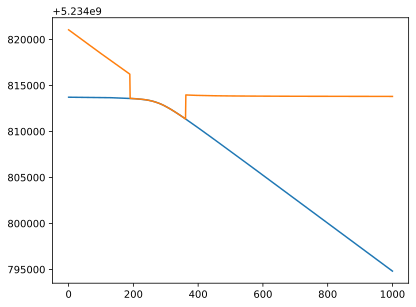

In [75]:
# Crosstalk matrix between S1 and S2
# 1 - Upper pad of qb1
# 2 - Lower pad of qb1
# 3 - Upper pad of qb2
# 4 - Lower pad of qb2
C11 = (147.026 - 37.72 - 0.00659 - 0.006)*1e-15
C12 = 37.72464*1e-15
C13 = 0.00659*1e-15
C14 = 0.00603*1e-15
C22 = (146.96 - 37.72 - 0.00712 - 0.00646)*1e-15
C23 = 0.00712*1e-15
C24 = 0.00646*1e-15
C33 = (147.906 - 37.685 - 0.00659 - 0.00712)*1e-15
C34 = 37.685*1e-15
C44 = (146.4745 - 0.00603 - 0.00646 - 37.685)*1e-15

cir = Network([
    C(0, 1, C11),
    C(1, 2, C12),
    C(1, 3, C13),
    C(1, 4, C14),
    C(2, 3, C23),
    C(2, 0, C22),
    C(2, 4, C24),
    C(0, 3, C33),
    C(3, 4, C34),
    C(0, 4, C44),
    J(2, 1, 'Lj1'),
    J(4, 3, 'Lj2'),
    ])
Lj1_list = np.linspace(10.008e-9,10.0081e-9,1001)
freqs = cir.eigenfrequencies(Lj1=Lj1_list, Lj2 = 10e-9)
energy_diff_mask = abs(freqs[0] - freqs[1]) > 0

g_12 = abs(freqs[0][energy_diff_mask] - freqs[1][energy_diff_mask]).min()/2
# df.loc['spurious crosstalk (shared) [kHz]/2pi'] = [g_12/1e3, g_12/1e3]
print(f"Crosstalk coupling strength: {g_12/1e3 :.2f} kHz")
plt.plot(freqs[0])
plt.plot(freqs[1])

# Note: the crosstalk seems too small to be diagonalised correctly with qucat. We can extract an upper limit by checking the smallest nonzero distance between modes.

### Target parameters 
We set design parameters (CPW traces, permittivity...) and target parameters (frequencies, coupling) 

In [4]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.4e9, 7.2e9, 7.6e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array([6.9e9, 7.1e9])
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma_s = 89e-15
c_sigma_a = 100e-15

chi = 0.5e6
kappa_target = 1e6
qubit_freq_target = [5e9, 4.5e9, 5.1e9]

g_coupling_target = 90e6

def get_g(EC, Ej, c_coupling, c_r, wr):
    # From Manenti and Motta book
    g = EC/ (e_charge) * (Ej/EC/2)**(1/4) * c_coupling / (c_r) * np.sqrt(2*planck_h * wr * (c_r))
    return g

### Optimization function
We build the effective circuit and quantize it using QuCAT, tuning the coupling capacitances and Ljs to match the coupling strength targets.

Qubit and resonators are modeled as grounded LC resonators.

In [66]:
# # The full optimization seems to complicated to be solved with fsolve or other minimization tool.  let's focus on s1-a now

# def minimize_func(x, c_rr = None, l_rr = None, c_cr = None, l_cr = None, qubit_freq_target = None, 
#                   g_coupling_target = None, chi = None):
#     c_r_s1 = abs(x[0])*1e-15
#     c_r_a = abs(x[1])*1e-15
#     c_c_s1_a_sensing_side = abs(x[2])*1e-15
#     c_c_s1_a_ancilla_side = abs(x[3])*1e-15
#     Lj_s1 = abs(x[4])*1e-9
#     Lj_a = abs(x[5])*1e-9

#     EC_s = e_charge**2/(c_sigma_s)/2/planck_h
#     EC_a = e_charge**2/(c_sigma_a)/2/planck_h
#     Ic_s1 = get_Ic_from_Lj(Lj_s1)
#     Ej_s1 = Ic_s1*phi0/2/pi/planck_h
#     Ic_a = get_Ic_from_Lj(Lj_a)
#     Ej_a = Ic_a*phi0/2/pi/planck_h

#     cir = Network([
#         C(0,1, c_sigma_s - c_r_s1 - c_c_s1_a_sensing_side), # sensing 1
#         J(0,1, Lj_s1),
#         C(0,2, c_sigma_a - c_r_a - c_c_s1_a_ancilla_side), # ancilla
#         J(0,2, Lj_a),

#         C(0,3, c_rr[0] - c_r_s1), # readout resonator sensing 1
#         L(0,3, l_rr[0]),
#         C(0,4, c_rr[2] - c_r_a), # readout resonator ancilla
#         L(0,4, l_rr[2]),

#         C(0, 5, c_cr[0] - c_c_s1_a_sensing_side - c_c_s1_a_ancilla_side), # coupling resonator between sensing 1 to ancilla
#         L(0, 5, l_cr[0]),

#         C(1, 3, c_r_s1), # sensing 1 - readout resonator 1
#         C(2, 4, c_r_a), # ancilla - readout resonator ancilla

#         C(1, 5, c_c_s1_a_sensing_side), # sensing 1 - coupling resonator
#         C(2, 5, c_c_s1_a_ancilla_side), # ancilla - coupling resonator

#     ])
#     chi_s1 = cir.kerr()[0, 3]
#     chi_a = cir.kerr()[1, 4]

#     g_s1_a_sensing_side = get_g(EC_s, Ej_s1, c_c_s1_a_sensing_side, c_cr[0], cplr_freq_target[0])
#     g_s1_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s1_a_ancilla_side, c_cr[0], cplr_freq_target[0])

#     H = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
#                     taylor = 7,
#                     excitations = [6, 6, 2, 2, 2])
#     eigs = H.eigenenergies().real
#     eigs -= eigs[0]

#     freq_qb_1 = eigs[1]
#     freq_qb_a = eigs[2]

#     err_chi_s1 = abs((chi_s1 - chi) / 1e6)
#     err_chi_a = abs((chi_a - chi) / 1e6)

#     err_g_s1_a_sensing_side = abs((g_s1_a_sensing_side - g_coupling_target) / 1e9)
#     err_g_s1_a_ancilla_side = abs((g_s1_a_ancilla_side - g_coupling_target) / 1e9)

#     err_freq_s1 = abs((freq_qb_1 - qubit_freq_target[0]) / 1e9)
#     err_freq_a = abs((freq_qb_a - qubit_freq_target[2]) / 1e9)
#     # _ = cir.f_k_A_chi(pretty_print=True)
#     print(err_chi_s1, err_chi_a, err_g_s1_a_sensing_side, err_g_s1_a_ancilla_side, err_freq_s1, err_freq_a)
#     return err_chi_s1, err_chi_a, err_g_s1_a_sensing_side, err_g_s1_a_ancilla_side, err_freq_s1, err_freq_a
# minimize_func([4, 3, 3, 3, 15, 8], c_rr, l_rr, c_cr, l_cr, qubit_freq_target, g_coupling_target, chi)

In [213]:

def minimize_func(x, c_cr = None, l_cr = None, qubit_freq_target = None, 
                  g_coupling_target = None):
    c_c_s1_a_sensing_side =  abs(x[3])*1e-15
    c_c_s1_a_ancilla_side = abs(x[4])*1e-15

    c_c_s2_a_sensing_side = abs(x[5])*1e-15
    c_c_s2_a_ancilla_side = abs(x[6])*1e-15

    Lj_s1 = abs(x[0])*1e-9
    Lj_s2 = abs(x[1])*1e-9
    Lj_a = abs(x[2])*1e-9

    EC_s = e_charge**2/(c_sigma_s)/2/planck_h
    EC_a = e_charge**2/(c_sigma_a)/2/planck_h
    Ic_s1 = get_Ic_from_Lj(Lj_s1)
    Ej_s1 = Ic_s1*phi0/2/pi/planck_h
    Ic_s2 = get_Ic_from_Lj(Lj_s2)
    Ej_s2 = Ic_s2*phi0/2/pi/planck_h
    Ic_a = get_Ic_from_Lj(Lj_a)
    Ej_a = Ic_a*phi0/2/pi/planck_h

    cir = Network([
        C(0,1, c_sigma_s - c_c_s1_a_sensing_side), # sensing 1
        J(0,1, Lj_s1),
        C(0,2, c_sigma_s - c_c_s2_a_sensing_side), # sensing 2
        J(0,2, Lj_s2),
        C(0,3, c_sigma_a - c_c_s1_a_ancilla_side - c_c_s2_a_ancilla_side), # ancilla
        J(0,3, Lj_a),

        C(0, 4, c_cr[0] - c_c_s1_a_ancilla_side - c_c_s1_a_sensing_side), # coupling resonator between sensing 1 to ancilla
        L(0, 4, l_cr[0]),
        C(0, 5, c_cr[1]- c_c_s2_a_ancilla_side - c_c_s2_a_sensing_side), # coupling resonator between sensing 2 to ancilla
        L(0, 5, l_cr[1]),

        C(1, 4, c_c_s1_a_sensing_side), # sensing 1 - coupling resonator
        C(3, 4, c_c_s1_a_ancilla_side), # ancilla - coupling resonator

        C(2, 5, c_c_s2_a_sensing_side), # sensing 2 - coupling resonator
        C(3, 5, c_c_s2_a_ancilla_side), # ancilla - coupling resonator

    ])

    g_s1_a_sensing_side = get_g(EC_s, Ej_s1, c_c_s1_a_sensing_side, c_cr[0], cplr_freq_target[0])
    g_s1_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s1_a_ancilla_side, c_cr[0], cplr_freq_target[0])

    g_s2_a_sensing_side = get_g(EC_s, Ej_s2, c_c_s2_a_sensing_side, c_cr[1], cplr_freq_target[1])
    g_s2_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s2_a_ancilla_side, c_cr[1], cplr_freq_target[1])

    H = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
                    taylor = 8,
                    excitations = [5, 5, 5, 2, 2])
    eigs = H.eigenenergies().real
    eigs -= eigs[0]

    # expected_freq_s1 = 1/np.sqrt(c_sigma_s*Lj_s1) / 2 / np.pi - EC_s
    # expected_freq_s2 = 1/np.sqrt(c_sigma_s*Lj_s2) / 2 / np.pi - EC_s
    # expected_freq_a = 1/np.sqrt(c_sigma_a*Lj_a) / 2 / np.pi - EC_a
    # print(expected_freq_s1, expected_freq_s2, expected_freq_a)
    # for i in range(1, 4):
    #     min_eig = np.argmin([abs(eigs[i] - expected_freq_s1), abs(eigs[i] - expected_freq_s2), abs(eigs[i] - expected_freq_a)])
    #     if min_eig == 0:
    #         freq_qb_1 = eigs[i]
    #     elif min_eig == 1:
    #         freq_qb_2 = eigs[i]
    #     else:
    #         freq_qb_a = eigs[i]

    freq_qb_2 = eigs[1]
    freq_qb_1 = eigs[2]
    freq_qb_a = eigs[3]

    err_g_s1_a_sensing_side = abs((g_s1_a_sensing_side - g_coupling_target) / 1e9)
    err_g_s1_a_ancilla_side = abs((g_s1_a_ancilla_side - g_coupling_target) / 1e9)
    err_g_s2_a_sensing_side = abs((g_s2_a_sensing_side - g_coupling_target) / 1e9)
    err_g_s2_a_ancilla_side = abs((g_s2_a_ancilla_side - g_coupling_target) / 1e9)
    print(freq_qb_1, freq_qb_2, freq_qb_a)
    err_freq_s1 = abs((freq_qb_1 - qubit_freq_target[0]) / 1e9)
    err_freq_s2 = abs((freq_qb_2 - qubit_freq_target[1]) / 1e9)
    err_freq_a = abs((freq_qb_a - qubit_freq_target[2]) / 1e9)
    # _ = cir.f_k_A_chi(pretty_print=True)
    print(err_freq_s1, err_freq_s2, err_freq_a, err_g_s1_a_sensing_side, err_g_s1_a_ancilla_side, err_g_s2_a_sensing_side, err_g_s2_a_ancilla_side)

    return err_freq_s1, err_freq_s2, err_freq_a, err_g_s1_a_sensing_side, err_g_s1_a_ancilla_side, err_g_s2_a_sensing_side, err_g_s2_a_ancilla_side

    # return err_chi_s1, err_chi_s2, err_chi_a, err_g_s1_a_sensing_side, err_g_s1_a_ancilla_side, err_g_s2_a_sensing_side, err_g_s2_a_ancilla_side, err_freq_s1, err_freq_s2, err_freq_a


In [214]:
minimize_func([10.7, 12.7,  9.3,  5,5,5,5], c_cr, l_cr, qubit_freq_target, g_coupling_target)

4930115051.342769 4507121079.449419 5014962341.220902
0.06988494865723133 0.007121079449419022 0.08503765877909755 0.003074143758699462 0.0016723325332670062 0.0017557568279009163 0.0008878897121455371


(0.06988494865723133,
 0.007121079449419022,
 0.08503765877909755,
 0.003074143758699462,
 0.0016723325332670062,
 0.0017557568279009163,
 0.0008878897121455371)

In [215]:
solution = fsolve(minimize_func, [10.7, 12.7,  9.3,  5,5,5,5], args =(c_cr, l_cr, qubit_freq_target, g_coupling_target))

4930115051.342769 4507121079.449419 5014962341.220902
0.06988494865723133 0.007121079449419022 0.08503765877909755 0.003074143758699462 0.0016723325332670062 0.0017557568279009163 0.0008878897121455371
4930115051.342769 4507121079.449419 5014962341.220902
0.06988494865723133 0.007121079449419022 0.08503765877909755 0.003074143758699462 0.0016723325332670062 0.0017557568279009163 0.0008878897121455371
4930115051.342769 4507121079.449419 5014962341.220902
0.06988494865723133 0.007121079449419022 0.08503765877909755 0.003074143758699462 0.0016723325332670062 0.0017557568279009163 0.0008878897121455371
4930114694.025099 4507121079.380635 5014962340.805735
0.0698853059749012 0.007121079380635262 0.08503765919426537 0.003074143411971271 0.0016723325332670062 0.0017557568279009163 0.0008878897121455371
4930115154.77565 4507121044.105522 5014962341.366898
0.06988484522434997 0.007121044105522156 0.08503765863310242 0.003074143758699462 0.0016723325332670062 0.0017557564860840738 0.000887889712

In [ ]:
def complete_system(x, c_rr = None, l_rr = None, c_cr = None, l_cr = None):
    c_r_s1 = abs(x[7])*1e-15
    c_r_s2 = abs(x[8])*1e-15
    c_r_a = abs(x[9])*1e-15
    c_c_s1_a_sensing_side =  abs(x[3])*1e-15
    c_c_s1_a_ancilla_side = abs(x[4])*1e-15

    c_c_s2_a_sensing_side = abs(x[5])*1e-15
    c_c_s2_a_ancilla_side = abs(x[6])*1e-15

    Lj_s1 = abs(x[0])*1e-9
    Lj_s2 = abs(x[1])*1e-9
    Lj_a = abs(x[2])*1e-9

    EC_s = e_charge**2/(c_sigma_s)/2/planck_h
    EC_a = e_charge**2/(c_sigma_a)/2/planck_h
    Ic_s1 = get_Ic_from_Lj(Lj_s1)
    Ej_s1 = Ic_s1*phi0/2/pi/planck_h
    Ic_s2 = get_Ic_from_Lj(Lj_s2)
    Ej_s2 = Ic_s2*phi0/2/pi/planck_h
    Ic_a = get_Ic_from_Lj(Lj_a)
    Ej_a = Ic_a*phi0/2/pi/planck_h

    cir = Network([
        C(0,1, c_sigma_s - c_r_s1 - c_c_s1_a_sensing_side), # sensing 1
        J(0,1, Lj_s1),
        C(0,2, c_sigma_s - c_r_s2 - c_c_s2_a_sensing_side), # sensing 2
        J(0,2, Lj_s2),
        C(0,3, c_sigma_a - c_r_a - c_c_s1_a_ancilla_side - c_c_s2_a_ancilla_side), # ancilla
        J(0,3, Lj_a),

        C(0,4, c_rr[0] - c_r_s1), # readout resonator sensing 1
        L(0,4, l_rr[0]),
        C(0,5, c_rr[1] - c_r_s2), # readout resonator sensing 2
        L(0,5, l_rr[1]),
        C(0,6, c_rr[2]- c_r_a), # readout resonator ancilla
        L(0,6, l_rr[2]),


        C(0, 7, c_cr[0] - c_c_s1_a_ancilla_side - c_c_s1_a_sensing_side), # coupling resonator between sensing 1 to ancilla
        L(0, 7, l_cr[0]),
        C(0, 8, c_cr[1]- c_c_s2_a_ancilla_side - c_c_s2_a_sensing_side), # coupling resonator between sensing 2 to ancilla
        L(0, 8, l_cr[1]),

        C(1, 4, c_r_s1), # sensing 1 - readout resonator 1
        C(2, 5, c_r_s2), # sensing 2 - readout resonator 2
        C(3, 6, c_r_a), # ancilla - readout resonator 2


        C(1, 7, c_c_s1_a_sensing_side), # sensing 1 - coupling resonator
        C(3, 7, c_c_s1_a_ancilla_side), # ancilla - coupling resonator

        C(2, 8, c_c_s2_a_sensing_side), # sensing 2 - coupling resonator
        C(3, 8, c_c_s2_a_ancilla_side), # ancilla - coupling resonator

    ])

    g_s1_a_sensing_side = get_g(EC_s, Ej_s1, c_c_s1_a_sensing_side, c_cr[0], cplr_freq_target[0])
    g_s1_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s1_a_ancilla_side, c_cr[0], cplr_freq_target[0])

    g_s2_a_sensing_side = get_g(EC_s, Ej_s2, c_c_s2_a_sensing_side, c_cr[1], cplr_freq_target[1])
    g_s2_a_ancilla_side = get_g(EC_a, Ej_a, c_c_s2_a_ancilla_side, c_cr[1], cplr_freq_target[1])

    gs = [g_s1_a_sensing_side, g_s1_a_ancilla_side, g_s2_a_sensing_side, g_s2_a_ancilla_side]
    H = cir.hamiltonian(modes = [0, 1, 2, 3, 4, 5, 6, 7],
                    taylor = 5,
                    excitations = [5, 5, 5, 2, 2, 2, 2, 2])
    return cir, H, gs

In [ ]:
solution

In [6]:
cir, H, gs = complete_system([11, 13,  9.5,  5,  5,  5, 5, 5,  5, 5], c_rr, l_rr, c_cr, l_cr)

 c:\Users\pc\Desktop\work\.venv\Lib\site-packages\qucat\core.py: 2446

In [ ]:
eigs = H.eigenenergies().real
eigs -= eigs[0]
print(eigs)

[0.00000000e+00 4.43879766e+09 4.84660916e+09 ... 8.91257860e+10
 8.95215982e+10 9.46936588e+10]


In [9]:
print(eigs[1:10])

[4.43879766e+09 4.84660916e+09 4.94983554e+09 6.91387828e+09
 7.11279763e+09 7.20680727e+09 7.40748934e+09 7.60692978e+09
 8.67263658e+09]
